In [1]:
!python --version

Python 3.11.11


In [ ]:
import shutil

shutil.make_archive('serialized_train_data', 'zip', 'data/serialized_train_data')  # includes both train & test folders

#/kaggle/working/data/serialized_train_data serialized_test_data  serialized_train_data

In [4]:
from IPython.display import FileLink
FileLink('serialized_train_data.zip')


/kaggle/working/serialized_data.zip

In [2]:
import os
import shutil

# Remove large folders or files manually
#shutil.rmtree('data/serialized_train_data', ignore_errors=True)
#shutil.rmtree('data/serialized_test_data', ignore_errors=True)

# Also delete the partially created zip file if it exists
if os.path.exists('/kaggle/working/serialized_train_data.zip'):
    os.remove('/kaggle/working/serialized_train_data.zip')


### data_preprocess

In [2]:
import os

import librosa
import numpy as np
from tqdm import tqdm

clean_train_folder = '/kaggle/input/valentini-dataset-16000hz/Valentini_16000Hz/clean_trainset_56spk_wav'
noisy_train_folder = '/kaggle/input/valentini-dataset-16000hz/Valentini_16000Hz/noisy_trainset_56spk_wav'
clean_test_folder = '/kaggle/input/valentini-dataset-16000hz/Valentini_16000Hz/clean_testset_wav'
noisy_test_folder = '/kaggle/input/valentini-dataset-16000hz/Valentini_16000Hz/noisy_testset_wav'
#serialized_train_folder = 'data/serialized_train_data'
#serialized_test_folder = 'data/serialized_test_data'

serialized_train_folder = '/kaggle/input/serialized-data/serialized_train_data'
serialized_test_folder = '/kaggle/input/serialized-data/serialized_test_data'

window_size = 2 ** 14  # about 1 second of samples
sample_rate = 16000


def slice_signal(file, window_size, stride, sample_rate):
    """
    Helper function for slicing the audio file
    by window size and sample rate with [1-stride] percent overlap (default 50%).
    """
    wav, sr = librosa.load(file, sr=sample_rate)
    hop = int(window_size * stride)
    slices = []
    for end_idx in range(window_size, len(wav), hop):
        start_idx = end_idx - window_size
        slice_sig = wav[start_idx:end_idx]
        slices.append(slice_sig)
    return slices


def process_and_serialize(data_type):
    """
    Serialize, down-sample the sliced signals and save on separate folder.
    """
    stride = 0.5

    if data_type == 'train':
        clean_folder = clean_train_folder
        noisy_folder = noisy_train_folder
        serialized_folder = serialized_train_folder
    else:
        clean_folder = clean_test_folder
        noisy_folder = noisy_test_folder
        serialized_folder = serialized_test_folder
    if not os.path.exists(serialized_folder):
        os.makedirs(serialized_folder)

    # walk through the path, slice the audio file, and save the serialized result
    for root, dirs, files in os.walk(clean_folder):
        if len(files) == 0:
            continue
        for filename in tqdm(files, desc='Serialize and down-sample {} audios'.format(data_type)):
            clean_file = os.path.join(clean_folder, filename)
            noisy_file = os.path.join(noisy_folder, filename)
            # slice both clean signal and noisy signal
            clean_sliced = slice_signal(clean_file, window_size, stride, sample_rate)
            noisy_sliced = slice_signal(noisy_file, window_size, stride, sample_rate)
            # serialize - file format goes [original_file]_[slice_number].npy
            # ex) p293_154.wav_5.npy denotes 5th slice of p293_154.wav file
            for idx, slice_tuple in enumerate(zip(clean_sliced, noisy_sliced)):
                pair = np.array([slice_tuple[0], slice_tuple[1]])
                np.save(os.path.join(serialized_folder, '{}_{}'.format(filename, idx)), arr=pair)


def data_verify(data_type):
    """
    Verifies the length of each data after pre-process.
    """
    if data_type == 'train':
        serialized_folder = serialized_train_folder
    else:
        serialized_folder = serialized_test_folder

    for root, dirs, files in os.walk(serialized_folder):
        for filename in tqdm(files, desc='Verify serialized {} audios'.format(data_type)):
            data_pair = np.load(os.path.join(root, filename))
            if data_pair.shape[1] != window_size:
                print('Snippet length not {} : {} instead'.format(window_size, data_pair.shape[1]))
                break


#if __name__ == '__main__':
    #process_and_serialize('train')
    #data_verify('train')
    #process_and_serialize('test')
    #data_verify('test')


### model

In [3]:
import torch
import torch.nn as nn
from torch.nn.modules import Module
from torch.nn.parameter import Parameter


class VirtualBatchNorm1d(Module):
    """
    Module for Virtual Batch Normalization.

    Implementation borrowed and modified from Rafael_Valle's code + help of SimonW from this discussion thread:
    https://discuss.pytorch.org/t/parameter-grad-of-conv-weight-is-none-after-virtual-batch-normalization/9036
    """

    def __init__(self, num_features, eps=1e-5):
        super().__init__()
        # batch statistics
        self.num_features = num_features
        self.eps = eps  # epsilon
        # define gamma and beta parameters
        self.gamma = Parameter(torch.normal(mean=1.0, std=0.02, size=(1, num_features, 1)))
        self.beta = Parameter(torch.zeros(1, num_features, 1))

    def get_stats(self, x):
        """
        Calculates mean and mean square for given batch x.
        Args:
            x: tensor containing batch of activations
        Returns:
            mean: mean tensor over features
            mean_sq: squared mean tensor over features
        """
        mean = x.mean(2, keepdim=True).mean(0, keepdim=True)
        mean_sq = (x ** 2).mean(2, keepdim=True).mean(0, keepdim=True)
        return mean, mean_sq

    def forward(self, x, ref_mean, ref_mean_sq):
        """
        Forward pass of virtual batch normalization.
        Virtual batch normalization require two forward passes
        for reference batch and train batch, respectively.

        Args:
            x: input tensor
            ref_mean: reference mean tensor over features
            ref_mean_sq: reference squared mean tensor over features
        Result:
            x: normalized batch tensor
            ref_mean: reference mean tensor over features
            ref_mean_sq: reference squared mean tensor over features
        """
        mean, mean_sq = self.get_stats(x)
        if ref_mean is None or ref_mean_sq is None:
            # reference mode - works just like batch norm
            mean = mean.clone().detach()
            mean_sq = mean_sq.clone().detach()
            out = self.normalize(x, mean, mean_sq)
        else:
            # calculate new mean and mean_sq
            batch_size = x.size(0)
            new_coeff = 1. / (batch_size + 1.)
            old_coeff = 1. - new_coeff
            mean = new_coeff * mean + old_coeff * ref_mean
            mean_sq = new_coeff * mean_sq + old_coeff * ref_mean_sq
            out = self.normalize(x, mean, mean_sq)
        return out, mean, mean_sq

    def normalize(self, x, mean, mean_sq):
        """
        Normalize tensor x given the statistics.

        Args:
            x: input tensor
            mean: mean over features
            mean_sq: squared means over features

        Result:
            x: normalized batch tensor
        """
        assert mean_sq is not None
        assert mean is not None
        assert len(x.size()) == 3  # specific for 1d VBN
        if mean.size(1) != self.num_features:
            raise Exception('Mean tensor size not equal to number of features : given {}, expected {}'
                            .format(mean.size(1), self.num_features))
        if mean_sq.size(1) != self.num_features:
            raise Exception('Squared mean tensor size not equal to number of features : given {}, expected {}'
                            .format(mean_sq.size(1), self.num_features))

        std = torch.sqrt(self.eps + mean_sq - mean ** 2)
        x = x - mean
        x = x / std
        x = x * self.gamma
        x = x + self.beta
        return x

    def __repr__(self):
        return ('{name}(num_features={num_features}, eps={eps}'
                .format(name=self.__class__.__name__, **self.__dict__))


class Generator(nn.Module):
    """G"""

    def __init__(self):
        super().__init__()
        # encoder gets a noisy signal as input [B x 1 x 16384]
        self.enc1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=32, stride=2, padding=15)  # [B x 16 x 8192]
        self.enc1_nl = nn.PReLU()
        self.enc2 = nn.Conv1d(16, 32, 32, 2, 15)  # [B x 32 x 4096]
        self.enc2_nl = nn.PReLU()
        self.enc3 = nn.Conv1d(32, 32, 32, 2, 15)  # [B x 32 x 2048]
        self.enc3_nl = nn.PReLU()
        self.enc4 = nn.Conv1d(32, 64, 32, 2, 15)  # [B x 64 x 1024]
        self.enc4_nl = nn.PReLU()
        self.enc5 = nn.Conv1d(64, 64, 32, 2, 15)  # [B x 64 x 512]
        self.enc5_nl = nn.PReLU()
        self.enc6 = nn.Conv1d(64, 128, 32, 2, 15)  # [B x 128 x 256]
        self.enc6_nl = nn.PReLU()
        self.enc7 = nn.Conv1d(128, 128, 32, 2, 15)  # [B x 128 x 128]
        self.enc7_nl = nn.PReLU()
        self.enc8 = nn.Conv1d(128, 256, 32, 2, 15)  # [B x 256 x 64]
        self.enc8_nl = nn.PReLU()
        self.enc9 = nn.Conv1d(256, 256, 32, 2, 15)  # [B x 256 x 32]
        self.enc9_nl = nn.PReLU()
        self.enc10 = nn.Conv1d(256, 512, 32, 2, 15)  # [B x 512 x 16]
        self.enc10_nl = nn.PReLU()
        self.enc11 = nn.Conv1d(512, 1024, 32, 2, 15)  # [B x 1024 x 8]
        self.enc11_nl = nn.PReLU()

        # decoder generates an enhanced signal
        # each decoder output are concatenated with homologous encoder output,
        # so the feature map sizes are doubled
        self.dec10 = nn.ConvTranspose1d(in_channels=2048, out_channels=512, kernel_size=32, stride=2, padding=15)
        self.dec10_nl = nn.PReLU()  # out : [B x 512 x 16] -> (concat) [B x 1024 x 16]
        self.dec9 = nn.ConvTranspose1d(1024, 256, 32, 2, 15)  # [B x 256 x 32]
        self.dec9_nl = nn.PReLU()
        self.dec8 = nn.ConvTranspose1d(512, 256, 32, 2, 15)  # [B x 256 x 64]
        self.dec8_nl = nn.PReLU()
        self.dec7 = nn.ConvTranspose1d(512, 128, 32, 2, 15)  # [B x 128 x 128]
        self.dec7_nl = nn.PReLU()
        self.dec6 = nn.ConvTranspose1d(256, 128, 32, 2, 15)  # [B x 128 x 256]
        self.dec6_nl = nn.PReLU()
        self.dec5 = nn.ConvTranspose1d(256, 64, 32, 2, 15)  # [B x 64 x 512]
        self.dec5_nl = nn.PReLU()
        self.dec4 = nn.ConvTranspose1d(128, 64, 32, 2, 15)  # [B x 64 x 1024]
        self.dec4_nl = nn.PReLU()
        self.dec3 = nn.ConvTranspose1d(128, 32, 32, 2, 15)  # [B x 32 x 2048]
        self.dec3_nl = nn.PReLU()
        self.dec2 = nn.ConvTranspose1d(64, 32, 32, 2, 15)  # [B x 32 x 4096]
        self.dec2_nl = nn.PReLU()
        self.dec1 = nn.ConvTranspose1d(64, 16, 32, 2, 15)  # [B x 16 x 8192]
        self.dec1_nl = nn.PReLU()
        self.dec_final = nn.ConvTranspose1d(32, 1, 32, 2, 15)  # [B x 1 x 16384]
        self.dec_tanh = nn.Tanh()

        # initialize weights
        self.init_weights()

    def init_weights(self):
        """
        Initialize weights for convolution layers using Xavier initialization.
        """
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
                #nn.init.xavier_normal(m.weight.data)
                nn.init.xavier_normal_(m.weight.data)

    def forward(self, x, z):
        """
        Forward pass of generator.

        Args:
            x: input batch (signal)
            z: latent vector
        """
        # encoding step
        e1 = self.enc1(x)
        e2 = self.enc2(self.enc1_nl(e1))
        e3 = self.enc3(self.enc2_nl(e2))
        e4 = self.enc4(self.enc3_nl(e3))
        e5 = self.enc5(self.enc4_nl(e4))
        e6 = self.enc6(self.enc5_nl(e5))
        e7 = self.enc7(self.enc6_nl(e6))
        e8 = self.enc8(self.enc7_nl(e7))
        e9 = self.enc9(self.enc8_nl(e8))
        e10 = self.enc10(self.enc9_nl(e9))
        e11 = self.enc11(self.enc10_nl(e10))
        # c = compressed feature, the 'thought vector'
        c = self.enc11_nl(e11)

        # concatenate the thought vector with latent variable
        encoded = torch.cat((c, z), dim=1)

        # decoding step
        d10 = self.dec10(encoded)
        # dx_c : concatenated with skip-connected layer's output & passed nonlinear layer
        d10_c = self.dec10_nl(torch.cat((d10, e10), dim=1))
        d9 = self.dec9(d10_c)
        d9_c = self.dec9_nl(torch.cat((d9, e9), dim=1))
        d8 = self.dec8(d9_c)
        d8_c = self.dec8_nl(torch.cat((d8, e8), dim=1))
        d7 = self.dec7(d8_c)
        d7_c = self.dec7_nl(torch.cat((d7, e7), dim=1))
        d6 = self.dec6(d7_c)
        d6_c = self.dec6_nl(torch.cat((d6, e6), dim=1))
        d5 = self.dec5(d6_c)
        d5_c = self.dec5_nl(torch.cat((d5, e5), dim=1))
        d4 = self.dec4(d5_c)
        d4_c = self.dec4_nl(torch.cat((d4, e4), dim=1))
        d3 = self.dec3(d4_c)
        d3_c = self.dec3_nl(torch.cat((d3, e3), dim=1))
        d2 = self.dec2(d3_c)
        d2_c = self.dec2_nl(torch.cat((d2, e2), dim=1))
        d1 = self.dec1(d2_c)
        d1_c = self.dec1_nl(torch.cat((d1, e1), dim=1))
        out = self.dec_tanh(self.dec_final(d1_c))
        return out


class Discriminator(nn.Module):
    """D"""

    def __init__(self):
        super().__init__()
        # D gets a noisy signal and clear signal as input [B x 2 x 16384]
        negative_slope = 0.03
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=32, kernel_size=31, stride=2, padding=15)  # [B x 32 x 8192]
        self.vbn1 = VirtualBatchNorm1d(32)
        self.lrelu1 = nn.LeakyReLU(negative_slope)
        self.conv2 = nn.Conv1d(32, 64, 31, 2, 15)  # [B x 64 x 4096]
        self.vbn2 = VirtualBatchNorm1d(64)
        self.lrelu2 = nn.LeakyReLU(negative_slope)
        self.conv3 = nn.Conv1d(64, 64, 31, 2, 15)  # [B x 64 x 2048]
        self.dropout1 = nn.Dropout()
        self.vbn3 = VirtualBatchNorm1d(64)
        self.lrelu3 = nn.LeakyReLU(negative_slope)
        self.conv4 = nn.Conv1d(64, 128, 31, 2, 15)  # [B x 128 x 1024]
        self.vbn4 = VirtualBatchNorm1d(128)
        self.lrelu4 = nn.LeakyReLU(negative_slope)
        self.conv5 = nn.Conv1d(128, 128, 31, 2, 15)  # [B x 128 x 512]
        self.vbn5 = VirtualBatchNorm1d(128)
        self.lrelu5 = nn.LeakyReLU(negative_slope)
        self.conv6 = nn.Conv1d(128, 256, 31, 2, 15)  # [B x 256 x 256]
        self.dropout2 = nn.Dropout()
        self.vbn6 = VirtualBatchNorm1d(256)
        self.lrelu6 = nn.LeakyReLU(negative_slope)
        self.conv7 = nn.Conv1d(256, 256, 31, 2, 15)  # [B x 256 x 128]
        self.vbn7 = VirtualBatchNorm1d(256)
        self.lrelu7 = nn.LeakyReLU(negative_slope)
        self.conv8 = nn.Conv1d(256, 512, 31, 2, 15)  # [B x 512 x 64]
        self.vbn8 = VirtualBatchNorm1d(512)
        self.lrelu8 = nn.LeakyReLU(negative_slope)
        self.conv9 = nn.Conv1d(512, 512, 31, 2, 15)  # [B x 512 x 32]
        self.dropout3 = nn.Dropout()
        self.vbn9 = VirtualBatchNorm1d(512)
        self.lrelu9 = nn.LeakyReLU(negative_slope)
        self.conv10 = nn.Conv1d(512, 1024, 31, 2, 15)  # [B x 1024 x 16]
        self.vbn10 = VirtualBatchNorm1d(1024)
        self.lrelu10 = nn.LeakyReLU(negative_slope)
        self.conv11 = nn.Conv1d(1024, 2048, 31, 2, 15)  # [B x 2048 x 8]
        self.vbn11 = VirtualBatchNorm1d(2048)
        self.lrelu11 = nn.LeakyReLU(negative_slope)
        # 1x1 size kernel for dimension and parameter reduction
        self.conv_final = nn.Conv1d(2048, 1, kernel_size=1, stride=1)  # [B x 1 x 8]
        self.lrelu_final = nn.LeakyReLU(negative_slope)
        self.fully_connected = nn.Linear(in_features=8, out_features=1)  # [B x 1]
        self.sigmoid = nn.Sigmoid()

        # initialize weights
        self.init_weights()

    def init_weights(self):
        """
        Initialize weights for convolution layers using Xavier initialization.
        """
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                #nn.init.xavier_normal(m.weight.data)
                nn.init.xavier_normal_(m.weight.data)

    def forward(self, x, ref_x):
        """
        Forward pass of discriminator.

        Args:
            x: input batch (signal)
            ref_x: reference input batch for virtual batch norm
        """
        # reference pass
        ref_x = self.conv1(ref_x)
        ref_x, mean1, meansq1 = self.vbn1(ref_x, None, None)
        ref_x = self.lrelu1(ref_x)
        ref_x = self.conv2(ref_x)
        ref_x, mean2, meansq2 = self.vbn2(ref_x, None, None)
        ref_x = self.lrelu2(ref_x)
        ref_x = self.conv3(ref_x)
        ref_x = self.dropout1(ref_x)
        ref_x, mean3, meansq3 = self.vbn3(ref_x, None, None)
        ref_x = self.lrelu3(ref_x)
        ref_x = self.conv4(ref_x)
        ref_x, mean4, meansq4 = self.vbn4(ref_x, None, None)
        ref_x = self.lrelu4(ref_x)
        ref_x = self.conv5(ref_x)
        ref_x, mean5, meansq5 = self.vbn5(ref_x, None, None)
        ref_x = self.lrelu5(ref_x)
        ref_x = self.conv6(ref_x)
        ref_x = self.dropout2(ref_x)
        ref_x, mean6, meansq6 = self.vbn6(ref_x, None, None)
        ref_x = self.lrelu6(ref_x)
        ref_x = self.conv7(ref_x)
        ref_x, mean7, meansq7 = self.vbn7(ref_x, None, None)
        ref_x = self.lrelu7(ref_x)
        ref_x = self.conv8(ref_x)
        ref_x, mean8, meansq8 = self.vbn8(ref_x, None, None)
        ref_x = self.lrelu8(ref_x)
        ref_x = self.conv9(ref_x)
        ref_x = self.dropout3(ref_x)
        ref_x, mean9, meansq9 = self.vbn9(ref_x, None, None)
        ref_x = self.lrelu9(ref_x)
        ref_x = self.conv10(ref_x)
        ref_x, mean10, meansq10 = self.vbn10(ref_x, None, None)
        ref_x = self.lrelu10(ref_x)
        ref_x = self.conv11(ref_x)
        ref_x, mean11, meansq11 = self.vbn11(ref_x, None, None)
        # further pass no longer needed

        # train pass
        x = self.conv1(x)
        x, _, _ = self.vbn1(x, mean1, meansq1)
        x = self.lrelu1(x)
        x = self.conv2(x)
        x, _, _ = self.vbn2(x, mean2, meansq2)
        x = self.lrelu2(x)
        x = self.conv3(x)
        x = self.dropout1(x)
        x, _, _ = self.vbn3(x, mean3, meansq3)
        x = self.lrelu3(x)
        x = self.conv4(x)
        x, _, _ = self.vbn4(x, mean4, meansq4)
        x = self.lrelu4(x)
        x = self.conv5(x)
        x, _, _ = self.vbn5(x, mean5, meansq5)
        x = self.lrelu5(x)
        x = self.conv6(x)
        x = self.dropout2(x)
        x, _, _ = self.vbn6(x, mean6, meansq6)
        x = self.lrelu6(x)
        x = self.conv7(x)
        x, _, _ = self.vbn7(x, mean7, meansq7)
        x = self.lrelu7(x)
        x = self.conv8(x)
        x, _, _ = self.vbn8(x, mean8, meansq8)
        x = self.lrelu8(x)
        x = self.conv9(x)
        x = self.dropout3(x)
        x, _, _ = self.vbn9(x, mean9, meansq9)
        x = self.lrelu9(x)
        x = self.conv10(x)
        x, _, _ = self.vbn10(x, mean10, meansq10)
        x = self.lrelu10(x)
        x = self.conv11(x)
        x, _, _ = self.vbn11(x, mean11, meansq11)
        x = self.lrelu11(x)
        x = self.conv_final(x)
        x = self.lrelu_final(x)
        # reduce down to a scalar value
        x = torch.squeeze(x)
        x = self.fully_connected(x)
        return self.sigmoid(x)


### utils

In [4]:
import os

import numpy as np
import torch
from torch.utils import data

#from data_preprocess import serialized_test_folder, serialized_train_folder


def emphasis(signal_batch, emph_coeff=0.95, pre=True):
    """
    Pre-emphasis or De-emphasis of higher frequencies given a batch of signal.

    Args:
        signal_batch: batch of signals, represented as numpy arrays
        emph_coeff: emphasis coefficient
        pre: pre-emphasis or de-emphasis signals

    Returns:
        result: pre-emphasized or de-emphasized signal batch
    """
    result = np.zeros(signal_batch.shape)
    for sample_idx, sample in enumerate(signal_batch):
        for ch, channel_data in enumerate(sample):
            if pre:
                result[sample_idx][ch] = np.append(channel_data[0], channel_data[1:] - emph_coeff * channel_data[:-1])
            else:
                result[sample_idx][ch] = np.append(channel_data[0], channel_data[1:] + emph_coeff * channel_data[:-1])
    return result


class AudioDataset(data.Dataset):
    """
    Audio sample reader.
    """

    def __init__(self, data_type):

        if data_type == 'train':
            data_path = serialized_train_folder
        else:
            data_path = serialized_test_folder
        if not os.path.exists(data_path):
            raise FileNotFoundError('The {} data folder does not exist!'.format(data_type))

        self.data_type = data_type
        self.file_names = [os.path.join(data_path, filename) for filename in os.listdir(data_path)]

    def reference_batch(self, batch_size):
        """
        Randomly selects a reference batch from dataset.
        Reference batch is used for calculating statistics for virtual batch normalization operation.

        Args:
            batch_size(int): batch size

        Returns:
            ref_batch: reference batch
        """
        ref_file_names = np.random.choice(self.file_names, batch_size)
        ref_batch = np.stack([np.load(f) for f in ref_file_names])

        ref_batch = emphasis(ref_batch, emph_coeff=0.95)
        return torch.from_numpy(ref_batch).type(torch.FloatTensor)

    def __getitem__(self, idx):
        pair = np.load(self.file_names[idx])
        pair = emphasis(pair[np.newaxis, :, :], emph_coeff=0.95).reshape(2, -1)
        noisy = pair[1].reshape(1, -1)
        if self.data_type == 'train':
            clean = pair[0].reshape(1, -1)
            return torch.from_numpy(pair).type(torch.FloatTensor), torch.from_numpy(clean).type(
                torch.FloatTensor), torch.from_numpy(noisy).type(torch.FloatTensor)
        else:
            return os.path.basename(self.file_names[idx]), torch.from_numpy(noisy).type(torch.FloatTensor)

    def __len__(self):
        return len(self.file_names)


In [5]:
import matplotlib.pyplot as plt
import json
import os
from scipy.signal import spectrogram

# --- Loss Logging ---
def init_loss_dict():
    return {
        'd_clean_loss': [],
        'd_noisy_loss': [],
        'g_loss': [],
        'g_conditional_loss': []
    }

def update_loss_dict(loss_dict, d_clean, d_noisy, g, g_cond):
    loss_dict['d_clean_loss'].append(d_clean)
    loss_dict['d_noisy_loss'].append(d_noisy)
    loss_dict['g_loss'].append(g)
    loss_dict['g_conditional_loss'].append(g_cond)

def save_loss_plot(loss_dict, save_path='results/loss_plot.png'):
    plt.figure(figsize=(10, 6))
    for key, values in loss_dict.items():
        plt.plot(values, label=key)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Convergence')
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()

def save_loss_log(loss_dict, file_path='results/loss_log.json'):
    with open(file_path, 'w') as f:
        json.dump(loss_dict, f, indent=4)

# --- Spectrogram for Audio Check ---
def plot_spectrogram(audio, save_path, sample_rate=16000):
    f, t, Sxx = spectrogram(audio, fs=sample_rate)
    plt.figure(figsize=(8, 4))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud')
    plt.ylabel('Freq [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='dB')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()


### main

### Final Working Code

# generator parameters: 75453878
# discriminator parameters: 97473194


Epoch 1: d_clean_loss 0.1645, d_noisy_loss 0.5430, g_loss 1.5372, g_conditional_loss 1.4600: 100%|██████████| 25/25 [00:07<00:00,  3.16it/s]  
Test model and save generated audios: 100%|██████████| 5/5 [00:00<00:00, 24.96it/s]
Epoch 2: d_clean_loss 0.4295, d_noisy_loss 0.2037, g_loss 1.2162, g_conditional_loss 0.9887: 100%|██████████| 25/25 [00:07<00:00,  3.15it/s]
Test model and save generated audios: 100%|██████████| 5/5 [00:00<00:00, 21.79it/s]
Epoch 3: d_clean_loss 0.5227, d_noisy_loss 0.1577, g_loss 1.2494, g_conditional_loss 1.0741: 100%|██████████| 25/25 [00:07<00:00,  3.16it/s]
Test model and save generated audios: 100%|██████████| 5/5 [00:00<00:00, 23.60it/s]
Epoch 4: d_clean_loss 0.5643, d_noisy_loss 0.1538, g_loss 1.7367, g_conditional_loss 1.5006: 100%|██████████| 25/25 [00:07<00:00,  3.16it/s]
Test model and save generated audios: 100%|██████████| 5/5 [00:00<00:00, 24.45it/s]
Epoch 5: d_clean_loss 0.2227, d_noisy_loss 0.1952, g_loss 1.1894, g_conditional_loss 1.0942: 100%|

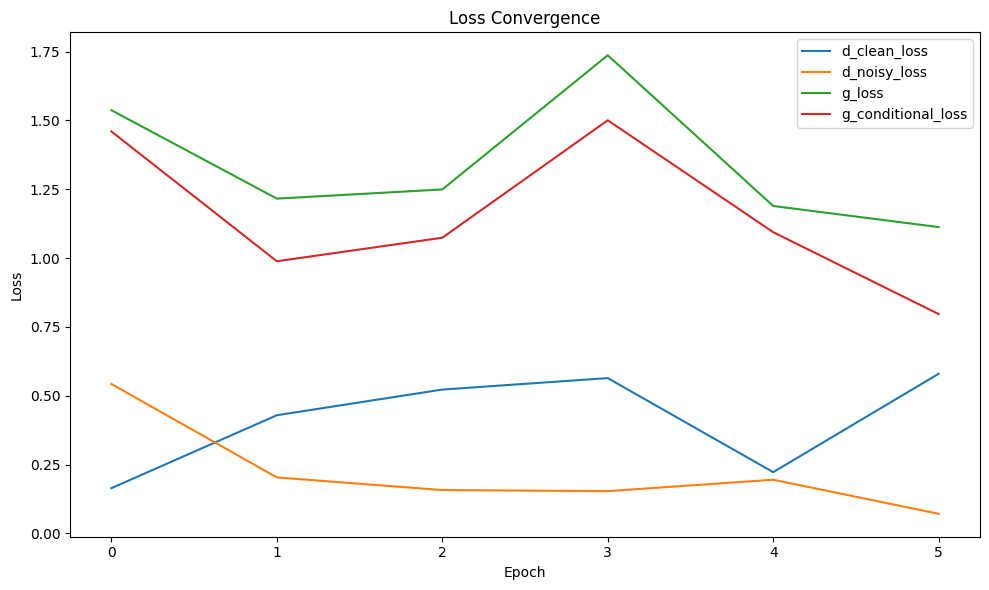

In [9]:
import argparse
import os

import torch
import torch.nn as nn
from scipy.io import wavfile
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm
import sys

#from data_preprocess import sample_rate
#from model import Generator, Discriminator
#from utils import AudioDataset, emphasis

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Train Audio Enhancement')
    parser.add_argument('--batch_size', default=4, type=int, help='train batch size') #50
    parser.add_argument('--num_epochs', default=20, type=int, help='train epochs number') # 86

    #opt = parser.parse_args()
    
    opt = parser.parse_args(args=[] if "__file__" not in globals() else None)
    BATCH_SIZE = opt.batch_size
    NUM_EPOCHS = opt.num_epochs

    # load data
    # Load full datasets
    full_train_dataset = AudioDataset(data_type='train')
    full_test_dataset = AudioDataset(data_type='test')

    # Generate reference batch from full dataset
    ref_batch = full_train_dataset.reference_batch(BATCH_SIZE)

    # Slice datasets for faster execution
    train_dataset = torch.utils.data.Subset(full_train_dataset, range(100))
    test_dataset = torch.utils.data.Subset(full_test_dataset, range(20))
    
    train_data_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
   
    # create D and G instances
    discriminator = Discriminator()
    generator = Generator()
    if torch.cuda.is_available():
        discriminator.cuda()
        generator.cuda()
        ref_batch = ref_batch.cuda()
    ref_batch = Variable(ref_batch)
    print("# generator parameters:", sum(param.numel() for param in generator.parameters()))
    print("# discriminator parameters:", sum(param.numel() for param in discriminator.parameters()))
    # optimizers
    g_optimizer = optim.RMSprop(generator.parameters(), lr=0.0001)
    d_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.0001)

    loss_tracker = init_loss_dict()
    os.makedirs('results', exist_ok=True)

    for epoch in range(NUM_EPOCHS):
        train_bar = tqdm(train_data_loader)
        for train_batch, train_clean, train_noisy in train_bar:

            # latent vector - normal distribution
            #z = nn.init.normal(torch.Tensor(train_batch.size(0), 1024, 8))
            z = torch.empty(train_batch.size(0), 1024, 8).normal_()

            
            if torch.cuda.is_available():
                train_batch, train_clean, train_noisy = train_batch.cuda(), train_clean.cuda(), train_noisy.cuda()
                z = z.cuda()
            train_batch, train_clean, train_noisy = Variable(train_batch), Variable(train_clean), Variable(train_noisy)
            z = Variable(z)

            # TRAIN D to recognize clean audio as clean
            # training batch pass
            discriminator.zero_grad()
            outputs = discriminator(train_batch, ref_batch)
            clean_loss = torch.mean((outputs - 1.0) ** 2)  # L2 loss - we want them all to be 1
            clean_loss.backward()

            # TRAIN D to recognize generated audio as noisy
            generated_outputs = generator(train_noisy, z)
            outputs = discriminator(torch.cat((generated_outputs, train_noisy), dim=1), ref_batch)
            noisy_loss = torch.mean(outputs ** 2)  # L2 loss - we want them all to be 0
            noisy_loss.backward()

            # d_loss = clean_loss + noisy_loss
            d_optimizer.step()  # update parameters

            # TRAIN G so that D recognizes G(z) as real
            generator.zero_grad()
            generated_outputs = generator(train_noisy, z)
            gen_noise_pair = torch.cat((generated_outputs, train_noisy), dim=1)
            outputs = discriminator(gen_noise_pair, ref_batch)

            g_loss_ = 0.5 * torch.mean((outputs - 1.0) ** 2)
            # L1 loss between generated output and clean sample
            l1_dist = torch.abs(torch.add(generated_outputs, torch.neg(train_clean)))
            g_cond_loss = 100 * torch.mean(l1_dist)  # conditional loss
            g_loss = g_loss_ + g_cond_loss

            # backprop + optimize
            g_loss.backward()
            g_optimizer.step()

            #train_bar.set_description(
             #   'Epoch {}: d_clean_loss {:.4f}, d_noisy_loss {:.4f}, g_loss {:.4f}, g_conditional_loss {:.4f}'
              #      .format(epoch + 1, clean_loss.data[0], noisy_loss.data[0], g_loss.data[0], g_cond_loss.data[0]))

            train_bar.set_description(
                'Epoch {}: d_clean_loss {:.4f}, d_noisy_loss {:.4f}, g_loss {:.4f}, g_conditional_loss {:.4f}'
                    .format(epoch + 1, clean_loss.item(), noisy_loss.item(), g_loss.item(), g_cond_loss.item()))

       # ----- Plot ### 
        update_loss_dict(loss_tracker,
                 d_clean=clean_loss.item(),
                 d_noisy=noisy_loss.item(),
                 g=g_loss.item(),
                 g_cond=g_cond_loss.item())

        # TEST model
        test_bar = tqdm(test_data_loader, desc='Test model and save generated audios')
        for test_file_names, test_noisy in test_bar:
            #z = nn.init.normal(torch.Tensor(test_noisy.size(0), 1024, 8))
            z = torch.empty(test_noisy.size(0), 1024, 8).normal_()

            if torch.cuda.is_available():
                test_noisy, z = test_noisy.cuda(), z.cuda()
            test_noisy, z = Variable(test_noisy), Variable(z)
            fake_speech = generator(test_noisy, z).data.cpu().numpy()  # convert to numpy array
            fake_speech = emphasis(fake_speech, emph_coeff=0.95, pre=False)

            for idx in range(fake_speech.shape[0]):
                generated_sample = fake_speech[idx]
                file_name = os.path.join('results',
                                         '{}_e{}.wav'.format(test_file_names[idx].replace('.npy', ''), epoch + 1))
                wavfile.write(file_name, sample_rate, generated_sample.T)

        os.makedirs('epochs', exist_ok=True)
        # save the model parameters for each epoch
        g_path = os.path.join('epochs', 'generator-{}.pkl'.format(epoch + 1))
        d_path = os.path.join('epochs', 'discriminator-{}.pkl'.format(epoch + 1))
        torch.save(generator.state_dict(), g_path)
        torch.save(discriminator.state_dict(), d_path)
    
    save_loss_plot(loss_tracker)
    save_loss_log(loss_tracker)


### test_audio

In [15]:
import argparse
import os

import numpy as np
import torch
import torch.nn as nn
from scipy.io import wavfile
from torch.autograd import Variable
from tqdm import tqdm

#from data_preprocess import slice_signal, window_size, sample_rate
#from model import Generator
#from utils import emphasis

if __name__ == '__main__':
    #parser = argparse.ArgumentParser(description='Test Single Audio Enhancement')
    #parser.add_argument('--file_name',default='/kaggle/input/valentini-dataset-16000hz/Valentini_16000Hz/noisy_testset_wav/p232_001.wav', type=str, required=True, help='audio file name')
    #parser.add_argument('--epoch_name',default='/kaggle/working/epochs/discriminator-1.pkl', type=str, required=True, help='generator epoch name')


    #opt = parser.parse_args()
    #FILE_NAME = opt.file_name
    #EPOCH_NAME = opt.epoch_name

    FILE_NAME = '/kaggle/input/valentini-dataset-16000hz/Valentini_16000Hz/clean_testset_wav/p232_003.wav'
    EPOCH_NAME = 'generator-5.pkl'

    generator = Generator()
    # generator.load_state_dict(torch.load('/kaggle/working/epochs/' + EPOCH_NAME, map_location='cpu'))
    EPOCH_PATH = os.path.join('/kaggle/working/epochs/', EPOCH_NAME)
    generator.load_state_dict(torch.load(EPOCH_PATH, map_location='cpu', weights_only=True))

    if torch.cuda.is_available():
        generator.cuda()

    noisy_slices = slice_signal(FILE_NAME, window_size, 1, sample_rate)
    enhanced_speech = []
    for noisy_slice in tqdm(noisy_slices, desc='Generate enhanced audio'):
        # z = nn.init.normal(torch.Tensor(1, 1024, 8))
        # z = torch.empty(train_batch.size(1), 1024, 8).normal_()
        z = torch.empty(1, 1024, 8).normal_()
        # z = torch.empty(noisy_slice.size(0), 1024, 8).normal_()

        noisy_slice = torch.from_numpy(emphasis(noisy_slice[np.newaxis, np.newaxis, :])).type(torch.FloatTensor)
        if torch.cuda.is_available():
            noisy_slice, z = noisy_slice.cuda(), z.cuda()
        noisy_slice, z = Variable(noisy_slice), Variable(z)
        generated_speech = generator(noisy_slice, z).data.cpu().numpy()
        generated_speech = emphasis(generated_speech, emph_coeff=0.95, pre=False)
        generated_speech = generated_speech.reshape(-1)
        enhanced_speech.append(generated_speech)

    enhanced_speech = np.array(enhanced_speech).reshape(1, -1)
    #file_name = os.path.join(os.path.dirname(FILE_NAME),
     #                        'enhanced_{}.wav'.format(os.path.basename(FILE_NAME).split('.')[0]))
    os.makedirs('enhanced', exist_ok=True)
    file_name = os.path.join('/kaggle/working/enhanced', 'enhanced_{}.wav'.format(os.path.basename(FILE_NAME).split('.')[0]))

    wavfile.write(file_name, sample_rate, enhanced_speech.T)


Generate enhanced audio: 100%|██████████| 7/7 [00:00<00:00, 97.61it/s]


In [13]:
!pip install pystoi pesq
!pip install librosa numpy scipy
!git clone https://github.com/aliutkus/speechmetrics.git
!pip install ./speechmetrics

!pip install git+https://github.com/aliutkus/speechmetrics.git

!pip install pyroomacoustics

fatal: destination path 'speechmetrics' already exists and is not an empty directory.
Processing ./speechmetrics
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/vBaiCai/python-pesq to /tmp/pip-install-ktlp0xw5/pypesq_f714037f6a61449eb257bc09461922d6
  Running command git clone --filter=blob:none --quiet https://github.com/vBaiCai/python-pesq /tmp/pip-install-ktlp0xw5/pypesq_f714037f6a61449eb257bc09461922d6
  Resolved https://github.com/vBaiCai/python-pesq to commit a76902d7dd371a172bfcbb52d80b2d1f1f9251dd
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/jfsantos/SRMRpy to /tmp/pip-install-ktlp0xw5/srmrpy_4d9f1ea954ed4774bb45d166eab5be8a
  Running command git clone --filter=blob:none --quiet https://github.com/jfsantos/SRMRpy /tmp/pip-install-ktlp0xw5/srmrpy_4d9f1ea954ed4774bb45d166eab5be8a
  Resolved https://github.com/jfsantos/SRMRpy to commit fee009779cef96bed34db3a7e31d10f3ad1ea133
  Preparing metadata (setup.py) ... done
  Cloning https://

In [14]:
from pesq import pesq
from pystoi import stoi
import numpy as np
import librosa
import speechmetrics
import soundfile as sf
import os
from pathlib import Path
from scipy.io import wavfile
import tqdm
from tabulate import tabulate  # Added for table formatting


def segmental_snr(clean, enhanced, frame_length=512):
    eps = 1e-8
    min_len = min(len(clean), len(enhanced))
    n_frames = min_len // frame_length
    ssnr = 0
    valid_frames = 0
    for i in range(n_frames):
        c = clean[i*frame_length:(i+1)*frame_length]
        e = enhanced[i*frame_length:(i+1)*frame_length]
        if len(c) != len(e) or len(c) == 0:
            continue
        noise = c - e
        snr_frame = 10 * np.log10(np.sum(c**2) / (np.sum(noise**2) + eps))
        ssnr += snr_frame
        valid_frames += 1
    return ssnr / valid_frames if valid_frames > 0 else float('nan')


def si_sdr(reference, estimation):
    reference = reference - np.mean(reference)
    estimation = estimation - np.mean(estimation)

    min_len = min(len(reference), len(estimation))
    reference = reference[:min_len]
    estimation = estimation[:min_len]

    scale = np.dot(reference, estimation) / np.dot(reference, reference)
    projection = scale * reference
    noise = estimation - projection
    si_sdr_value = 10 * np.log10(np.sum(projection**2) / (np.sum(noise**2) + 1e-8))
    return si_sdr_value


def process_dataset(clean_dir, enhanced_dir, output_dir):
    clean_files = [f for f in os.listdir(clean_dir) if f.endswith('.wav')]
    enhanced_files = [f for f in os.listdir(enhanced_dir) if f.endswith('.wav')]
    
    metrics = speechmetrics.load(['covl', 'csig', 'cbak'], window=None)
    results_table = []

    for clean_file in tqdm.tqdm(clean_files, desc="Processing files"):
        clean_path = os.path.join(clean_dir, clean_file)
        clean_file_prefix = clean_file.split('.')[0]
        enhanced_files_for_clean = [f for f in enhanced_files if f.startswith(clean_file_prefix)]

        if not enhanced_files_for_clean:
            continue
        
        for enhanced_file in enhanced_files_for_clean:
            enhanced_path = os.path.join(enhanced_dir, enhanced_file)

            clean, sr = librosa.load(clean_path, sr=16000)
            enhanced, _ = librosa.load(enhanced_path, sr=16000)

            min_len = min(len(clean), len(enhanced))
            clean = clean[:min_len]
            enhanced = enhanced[:min_len]

            try:
                pesq_score = pesq(sr, clean, enhanced, 'wb')
            except:
                pesq_score = float('nan')
            try:
                stoi_score = stoi(clean, enhanced, sr, extended=True)
            except:
                stoi_score = float('nan')

            enhanced_output_path = os.path.join(output_dir, f"enhanced_{enhanced_file}")
            clean_output_path = os.path.join(output_dir, f"clean_{clean_file}")
            sf.write(enhanced_output_path, enhanced, sr)
            sf.write(clean_output_path, clean, sr)

            try:
                metrics_result = metrics(enhanced, clean)
            except:
                metrics_result = {}

            ssnr_val = segmental_snr(clean, enhanced)

            fs_ref, ref = wavfile.read(clean_output_path)
            fs_est, est = wavfile.read(enhanced_output_path)

            if ref.ndim > 1:
                ref = ref[:, 0]
            if est.ndim > 1:
                est = est[:, 0]

            ref = ref.astype(np.float32)
            est = est.astype(np.float32)

            try:
                si_sdr_value = si_sdr(ref, est)
            except:
                si_sdr_value = float('nan')

            results_table.append({
                "Clean File": clean_file,
                "Enhanced File": enhanced_file,
                "PESQ": f"{pesq_score:.4f}" if not np.isnan(pesq_score) else "nan",
                "STOI": f"{stoi_score:.4f}" if not np.isnan(stoi_score) else "nan",
                "SI-SDR (dB)": f"{si_sdr_value:.2f}" if not np.isnan(si_sdr_value) else "nan",
                "SSNR": f"{ssnr_val:.2f}" if not np.isnan(ssnr_val) else "nan",
                "COVL": f"{metrics_result.get('covl', 'N/A'):.4f}" if 'covl' in metrics_result else "N/A",
                "CSIG": f"{metrics_result.get('csig', 'N/A'):.4f}" if 'csig' in metrics_result else "N/A",
                "CBAK": f"{metrics_result.get('cbak', 'N/A'):.4f}" if 'cbak' in metrics_result else "N/A"
            })

    print("\n\n=== Evaluation Metrics Table ===")
    print(tabulate(results_table, headers="keys", tablefmt="pretty"))


# Set directory paths (modify if needed)
clean_dir = '/kaggle/input/valentini-dataset-16000hz/Valentini_16000Hz/clean_testset_wav'
enhanced_dir = '/kaggle/working/results'
output_dir = '/kaggle/working/evaluated_results'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Run the evaluation
process_dataset(clean_dir, enhanced_dir, output_dir)


Processing files: 100%|██████████| 824/824 [00:11<00:00, 73.43it/s] 



=== Evaluation Metrics Table ===
+--------------+------------------------+--------+---------+-------------+--------+------+------+------+
|  Clean File  |     Enhanced File      |  PESQ  |  STOI   | SI-SDR (dB) |  SSNR  | COVL | CSIG | CBAK |
+--------------+------------------------+--------+---------+-------------+--------+------+------+------+
| p232_023.wav | p232_023.wav_14_e1.wav | 1.0457 | -0.0867 |   -64.24    | -8.30  | N/A  | N/A  | N/A  |
| p232_023.wav | p232_023.wav_14_e5.wav | 1.0810 | -0.0623 |   -43.17    | -8.25  | N/A  | N/A  | N/A  |
| p232_023.wav | p232_023.wav_14_e2.wav | 1.0499 | -0.0688 |   -52.57    | -6.58  | N/A  | N/A  | N/A  |
| p232_023.wav | p232_023.wav_14_e4.wav | 1.0756 | -0.0651 |   -43.64    | -7.69  | N/A  | N/A  | N/A  |
| p232_023.wav | p232_023.wav_14_e6.wav | 1.0848 | -0.0814 |   -43.05    | -8.56  | N/A  | N/A  | N/A  |
| p232_023.wav | p232_023.wav_14_e3.wav | 1.0546 | -0.0722 |   -45.54    | -7.86  | N/A  | N/A  | N/A  |
| p257_020.wav | p25

In [ ]:
from pesq import pesq
from pystoi import stoi
import numpy as np
import librosa
import speechmetrics
import soundfile as sf
import os
from pathlib import Path
from pyroomacoustics import metrics
#from pyroomacoustics.bss.eval import bss_eval_sources
#pip install pyroomacoustics


def segmental_snr(clean, enhanced, frame_length=512):
    eps = 1e-8
    min_len = min(len(clean), len(enhanced))
    n_frames = min_len // frame_length
    ssnr = 0
    valid_frames = 0
    for i in range(n_frames):
        c = clean[i*frame_length:(i+1)*frame_length]
        e = enhanced[i*frame_length:(i+1)*frame_length]
        if len(c) != len(e) or len(c) == 0:
            continue  # skip problematic frames
        noise = c - e
        snr_frame = 10 * np.log10(np.sum(c*2) / (np.sum(noise*2) + eps))
        ssnr += snr_frame
        valid_frames += 1
    return ssnr / valid_frames if valid_frames > 0 else float('nan')

def si_sdr(reference, estimation):
    """Compute Scale-Invariant SDR"""
    reference = reference - np.mean(reference)
    estimation = estimation - np.mean(estimation)

    # Make same length
    min_len = min(len(reference), len(estimation))
    reference = reference[:min_len]
    estimation = estimation[:min_len]

    # Projection of estimated signal onto reference
    scale = np.dot(reference, estimation) / np.dot(reference, reference)
    projection = scale * reference

    # Compute SI-SDR
    noise = estimation - projection
    si_sdr_value = 10 * np.log10(np.sum(projection * 2) / np.sum(noise * 2))
    return si_sdr_value
    
noisyfilepath = '/kaggle/input/valentini-dataset-16000hz/Valentini_16000Hz/noisy_testset_wav/p232_003.wav'
cleanfilepath = '/kaggle/input/valentini-dataset-16000hz/Valentini_16000Hz/clean_testset_wav/p232_003.wav'
enhancedfilepath = '/kaggle/working/enhanced/enhanced_p232_003.wav'

# Load clean and enhanced speech (same sample rate!)
noisy, sr = librosa.load(noisyfilepath, sr=16000)
clean, sr = librosa.load(cleanfilepath, sr=16000)
enhanced, _ = librosa.load(enhancedfilepath, sr=16000)

# Match length
min_len = min(len(clean), len(enhanced),len(noisy))
clean = clean[:min_len]
enhanced = enhanced[:min_len]
noisy = noisy[:min_len]

# PESQ (only works with 8k or 16k)
pesq_noisy_score = pesq(sr, clean, noisy, 'wb')  # 'wb' = wideband (16kHz)
pesq_enhanced_score = pesq(sr, clean, enhanced, 'wb')  # 'wb' = wideband (16kHz)

# STOI (intelligibility)
#stoi_score = stoi(clean, enhanced, sr, extended=True)
stoi_noisy = stoi(clean, noisy, sr, extended=True)
stoi_enhanced = stoi(clean, enhanced, sr, extended=True)

ssnr_val_noisy = segmental_snr(clean, noisy)
print("SSNR Noisy:", ssnr_val_noisy)

ssnr_val_enhanced = segmental_snr(clean, enhanced)
print("SSNR Enhanced:", ssnr_val_enhanced)

print("PESQ Noisy:", pesq_noisy_score)
print("PESQ Enhanced:", pesq_enhanced_score)

print("STOI Noisy:", stoi_noisy)
print("STOI Enhanced:", stoi_enhanced)


# Load WAV files For Noisy
fs_ref, ref = wavfile.read(cleanfilepath)
fs_est, est = wavfile.read(noisyfilepath)

# Convert to float32 and mono if stereo
if ref.ndim > 1:
    ref = ref[:, 0]
if est.ndim > 1:
    est = est[:, 0]

ref = ref.astype(np.float32)
est = est.astype(np.float32)

# Compute SI-SDR For Noisy
score_noisy = si_sdr(ref, est)
print(f"SI-SDR Noisy: {score_noisy:.2f} dB")

# Load WAV files for Enhanced
fs_ref, ref = wavfile.read(cleanfilepath)
fs_est, est = wavfile.read(enhancedfilepath)

# Convert to float32 and mono if stereo
if ref.ndim > 1:
    ref = ref[:, 0]
if est.ndim > 1:
    est = est[:, 0]

ref = ref.astype(np.float32)
est = est.astype(np.float32)

# Compute SI-SDR For Enhanced
score_enhanced = si_sdr(ref, est)
print(f"SI-SDR Enhanced: {score_enhanced:.2f} dB")

print(ssnr_val_noisy)
print(ssnr_val_enhanced)
print(pesq_noisy_score)
print(pesq_enhanced_score)
print(stoi_noisy)
print(stoi_enhanced)
print(score_noisy)
print(score_enhanced)

print("\n--- Evaluation Metrics ---")
print(f"          | Noisy    | Enhanced")
print(f"PESQ      | {pesq_noisy_score:.3f}    | {pesq_enhanced_score:.3f}")
print(f"STOI      | {stoi_noisy:.3f}    | {stoi_enhanced:.3f}")
print(f"SSNR      | {ssnr_val_noisy:.2f} dB  | {ssnr_val_enhanced:.2f} dB")
print(f"SI-SDR    | {score_noisy:.2f} dB  | {score_enhanced:.2f} dB")

# Output Cleanup

In [20]:
import os
import shutil

# Define directories and files to remove
dirs_to_remove = ['epochs', 'results', 'data','enhanced']
files_to_remove = ['state.db', 'enhanced_p232_001.wav']

# Remove directories
for dir in dirs_to_remove:
    if os.path.exists(dir):
        shutil.rmtree(dir)  # Removes directory and its contents
        print(f'{dir} directory has been removed.')
    else:
        print(f'{dir} directory does not exist.')

# Remove files
for file in files_to_remove:
    if os.path.exists(file):
        os.remove(file)  # Removes file
        print(f'{file} file has been removed.')
    else:
        print(f'{file} file does not exist.')


epochs directory does not exist.
results directory does not exist.
data directory does not exist.
final_models directory does not exist.
state.db file does not exist.
enhanced_p232_001.wav file has been removed.
